In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sp 
import statsmodels.stats as stats
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import pickle 

In [2]:
train_16 = pd.read_csv("../Data/train_2016_v2.csv")
# train_17 = pd.read_csv("../Data/train_2017.csv")
properties_16 = pd.read_csv("../Data/properties_2016.csv")
# properties_17 = pd.read_csv("../Data/properties_2017.csv")
# sample_sub = pd.read_csv('../Data/sample_submission.csv')

/Users/MAC/.pyenv/versions/anaconda3-5.0.1/envs/python_ana/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Train_16

In [3]:
print(train_16.dtypes)
print(train_16.transactiondate.values[:3])
train_16.tail()

parcelid             int64
logerror           float64
transactiondate     object
dtype: object
['2016-01-01' '2016-01-01' '2016-01-01']


,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


** transaction counts by transactiondate **

In [4]:
train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).agg(np.mean).reset_index().tail()

,transactiondate,logerror
347,2016-12-26,0.041100
348,2016-12-27,0.018247
349,2016-12-28,-0.002958
350,2016-12-29,0.022229
351,2016-12-30,0.044227


In [5]:
train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).size().reset_index(name="counts").tail()

,transactiondate,counts
347,2016-12-26,15
348,2016-12-27,51
349,2016-12-28,78
350,2016-12-29,117
351,2016-12-30,94


In [6]:
# 월별로 카운트와 평균, 최대, 최소 logerror를 출력 
logerrorbytransactiondate = train_16[["logerror", 'transactiondate']].groupby(np.array([x[:7] for x in train_16.transactiondate]),\
                                                  axis=0).agg([np.mean, np.max, np.min, np.std]).reset_index()
logerrorbytransactiondate.columns = ['y_month', 'mean', 'max', 'min', 'std']
logerrorbytransactiondate.tail()

,y_month,mean,max,min,std
7,2016-08,0.011573,3.436,-4.6050,0.161429
8,2016-09,0.016255,2.762,-1.7370,0.150357
9,2016-10,0.016342,1.749,-1.6050,0.134488
10,2016-11,0.014510,3.443,-0.9943,0.139693
11,2016-12,0.019122,2.387,-4.5100,0.189896


In [7]:
transaction_count_by_month = train_16[["logerror", 'transactiondate']].groupby(np.array([x[:7] for x in train_16.transactiondate]),\
                                                  axis=0).size().reset_index(name="count")
transaction_count_by_month.rename(columns={"index" : "y_month"}, inplace=True)
transaction_by_month = pd.merge(transaction_count_by_month, logerrorbytransactiondate, on="y_month")
del transaction_count_by_month
del logerrorbytransactiondate
transaction_by_month

,y_month,count,mean,max,min,std
0,2016-01,6556,0.015870,3.018,-4.6050,0.171525
1,2016-02,6333,0.016082,4.737,-2.9760,0.198599
2,2016-03,8652,0.009867,3.115,-2.3650,0.172171
3,2016-04,9311,0.006605,4.520,-2.3750,0.166560
4,2016-05,9961,0.006926,3.289,-2.3230,0.150861
5,2016-06,10922,0.007172,2.485,-2.3650,0.151433
6,2016-07,9947,0.011687,3.250,-2.6880,0.151663
7,2016-08,10476,0.011573,3.436,-4.6050,0.161429
8,2016-09,9575,0.016255,2.762,-1.7370,0.150357
9,2016-10,4977,0.016342,1.749,-1.6050,0.134488


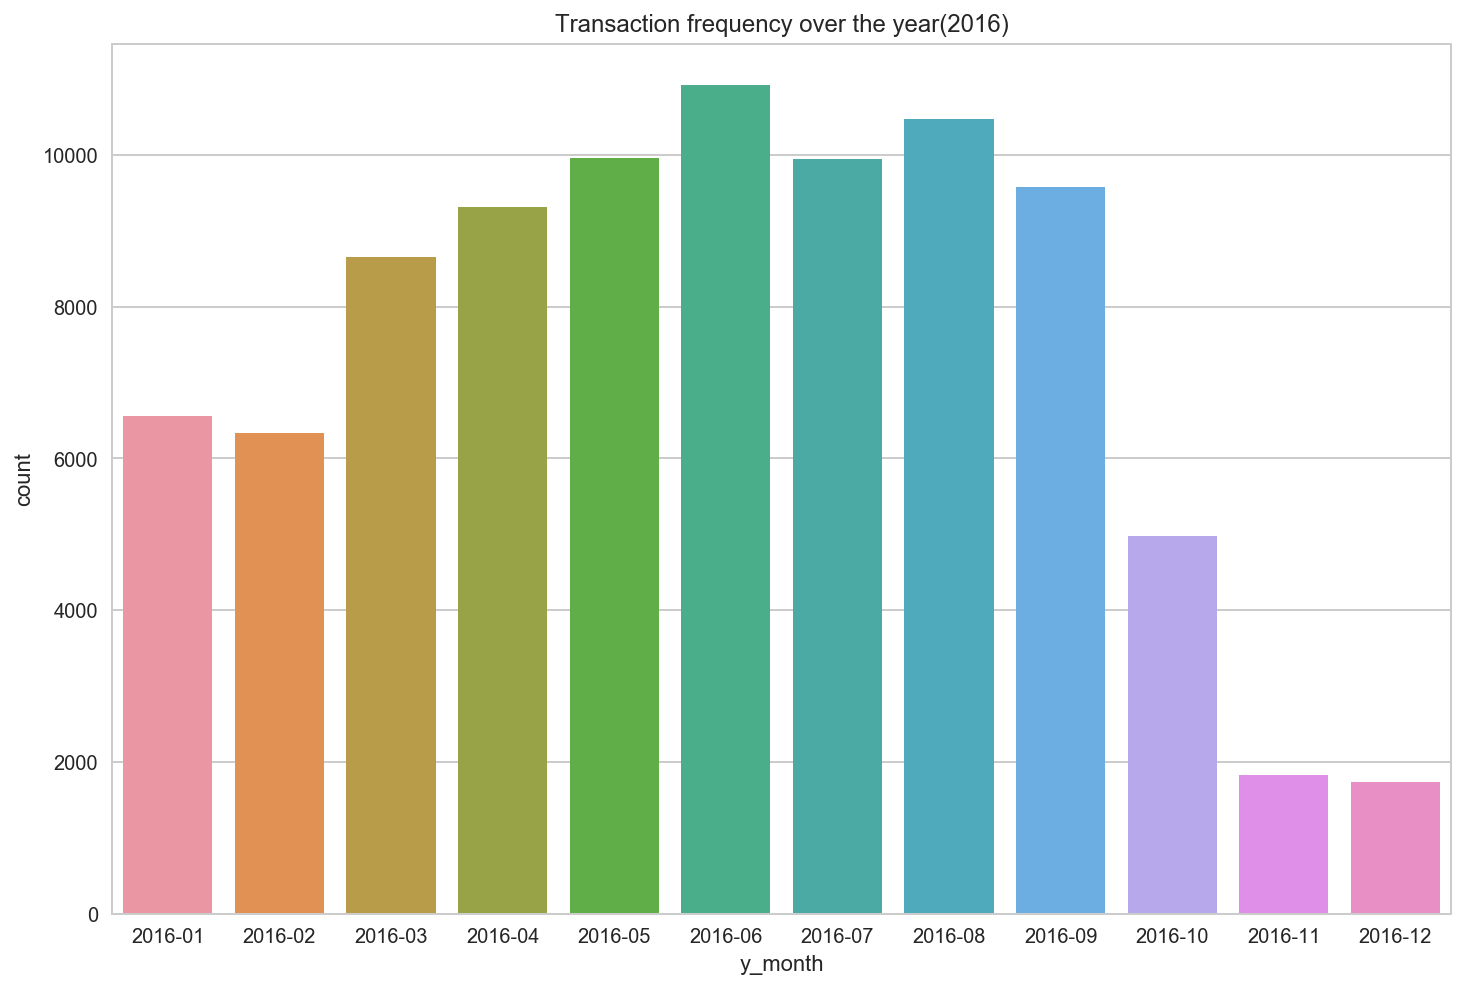

In [8]:
plt.figure(figsize=(12, 8))
plt.title("Transaction frequency over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['count'])
plt.show()
# 5, 6, 7, 8월에 transaction 이 많다. 
# 월별로 transaction frequency에 차이가 있다고 할 만 한가? -> 여러 해의 데이터가 필요하기 때문에 2016년 한 해 만으로는 검증하기 힘들다. 

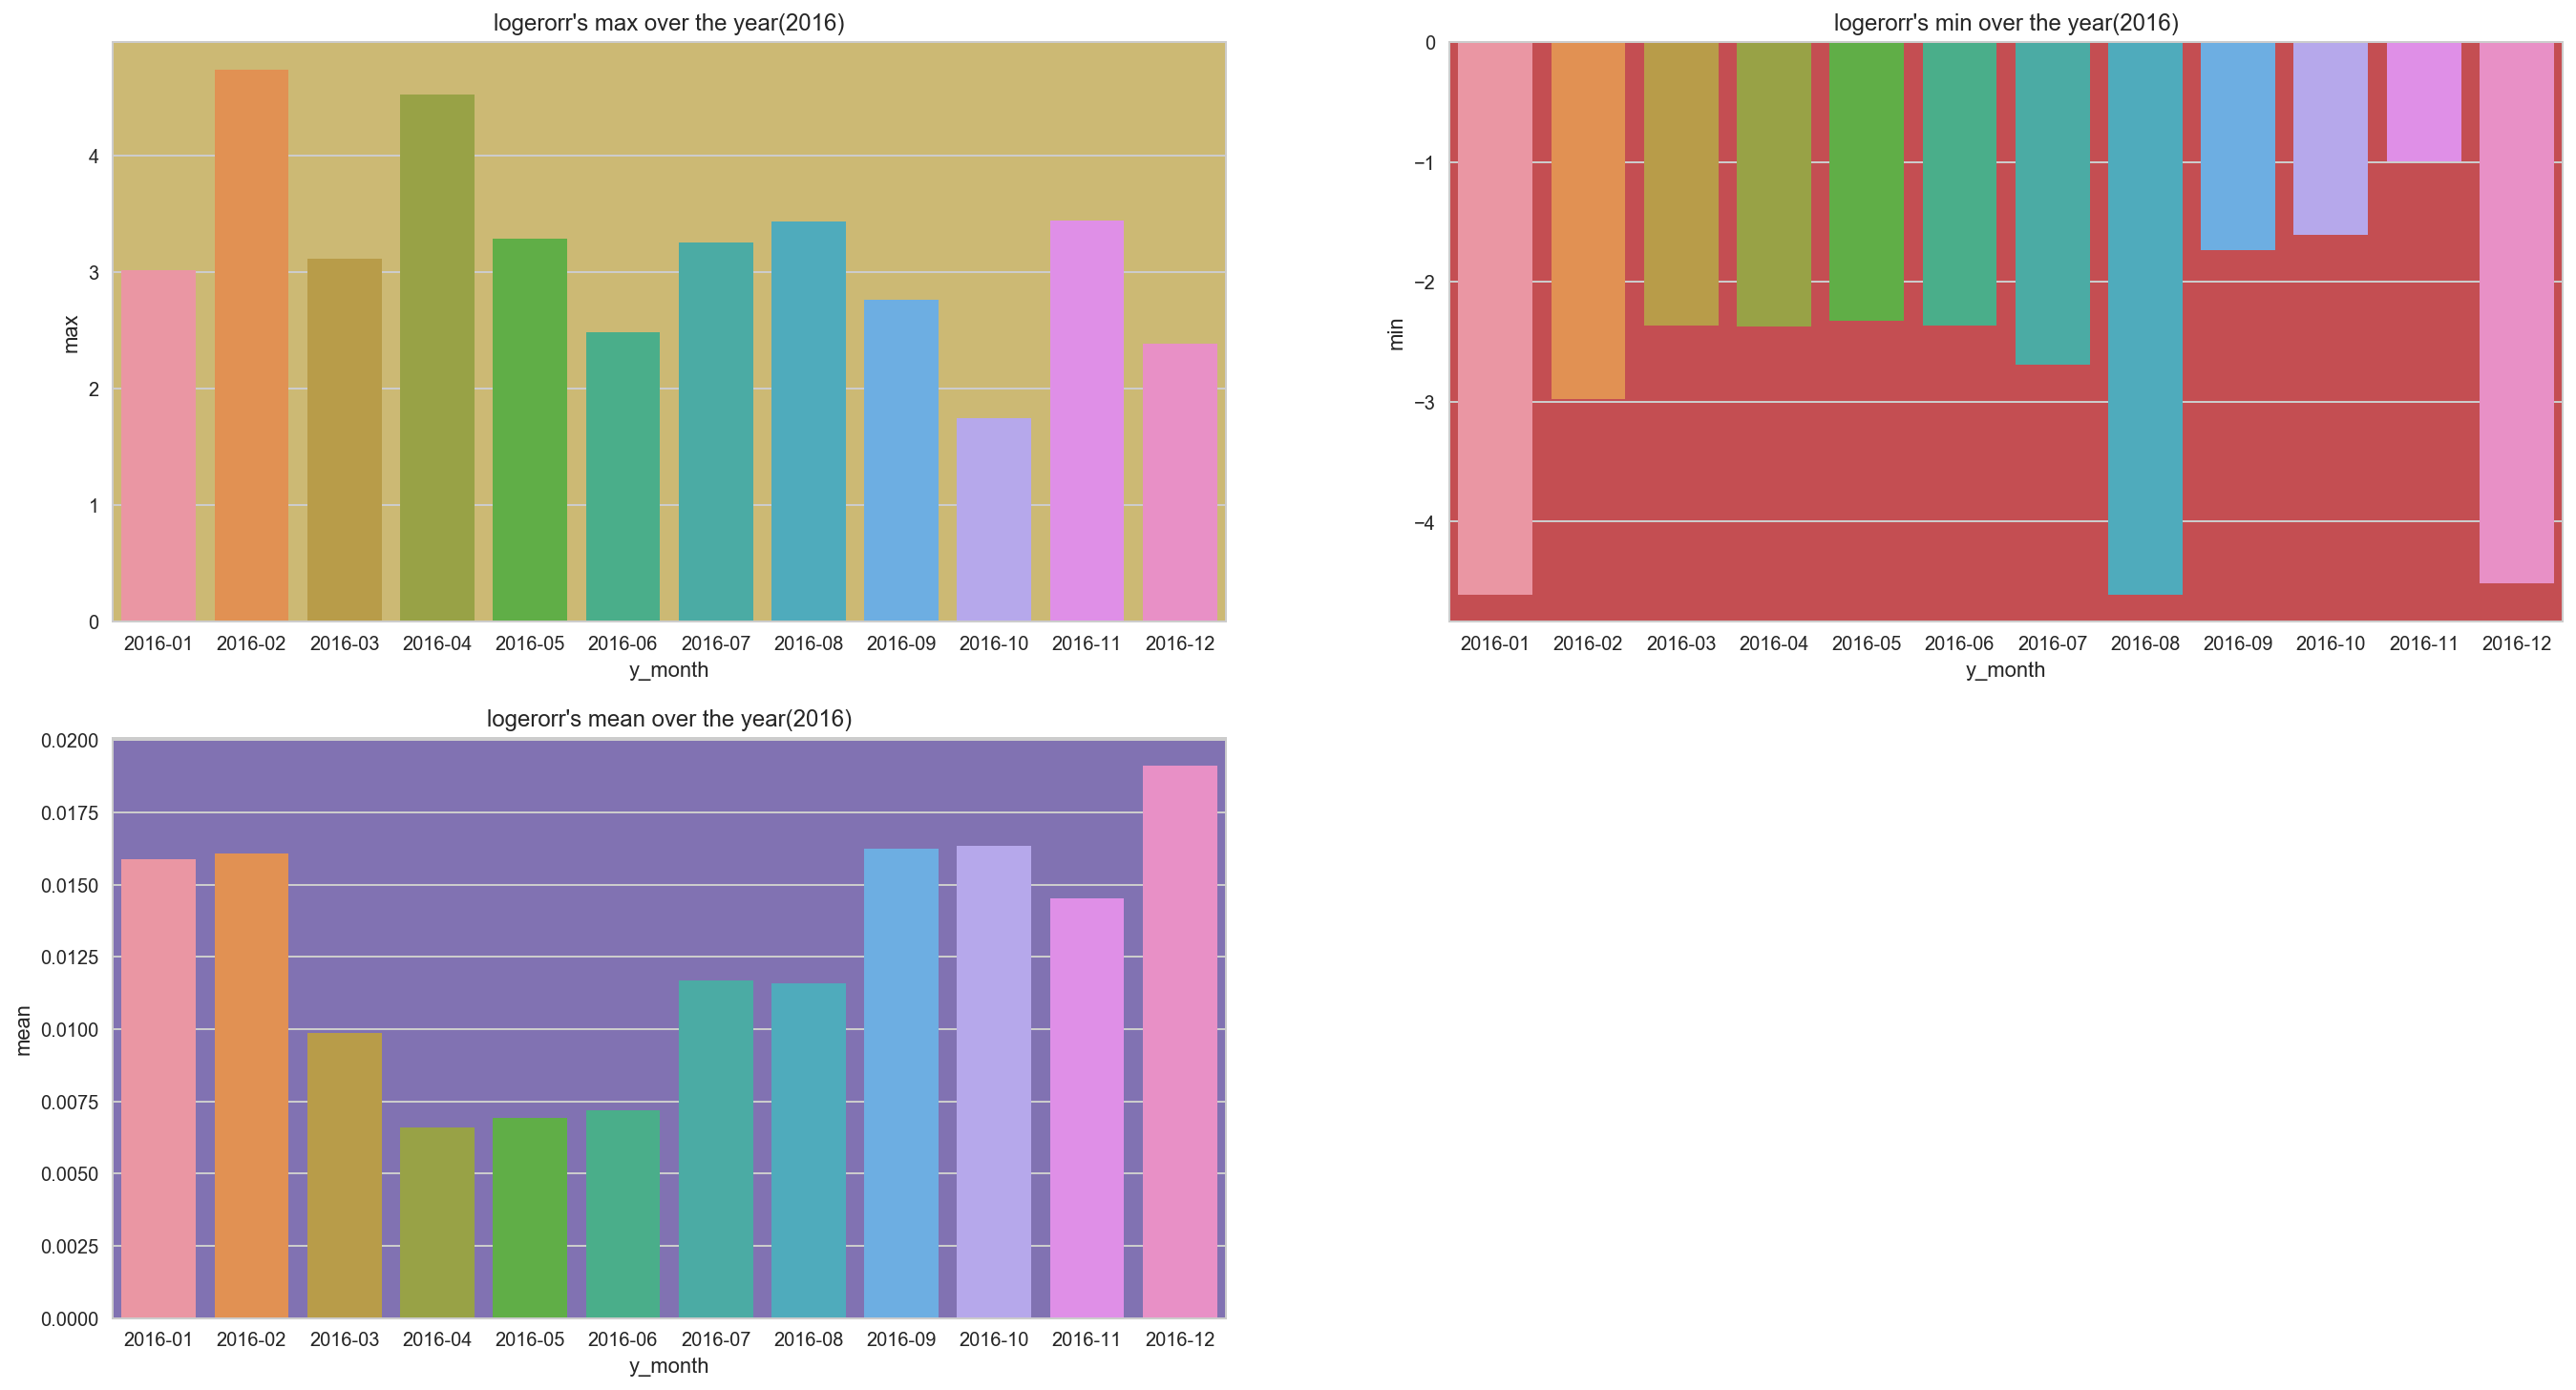

In [9]:
# f, ax = plt.subplots(figsize=(6, 15))
plt.rcParams["figure.figsize"] = (23, 19)
plt.subplot(3, 2, 1, facecolor='y')
plt.title("logerorr's max over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['max'])
plt.subplot(3, 2, 2, facecolor='r')
plt.title("logerorr's min over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['min'])
plt.subplot(3, 2, 3, facecolor='m')
plt.title("logerorr's mean over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['mean'])
# # 표준편차가 평균보다 훨씬 커서 그래프로 표현이 잘 안된다. 
# plt.errorbar(transaction_by_month['y_month'], transaction_by_month['mean'], transaction_by_month['std'],  marker='^')
plt.show()

### Normality test for the target 

In [10]:
train_16["logerror"].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

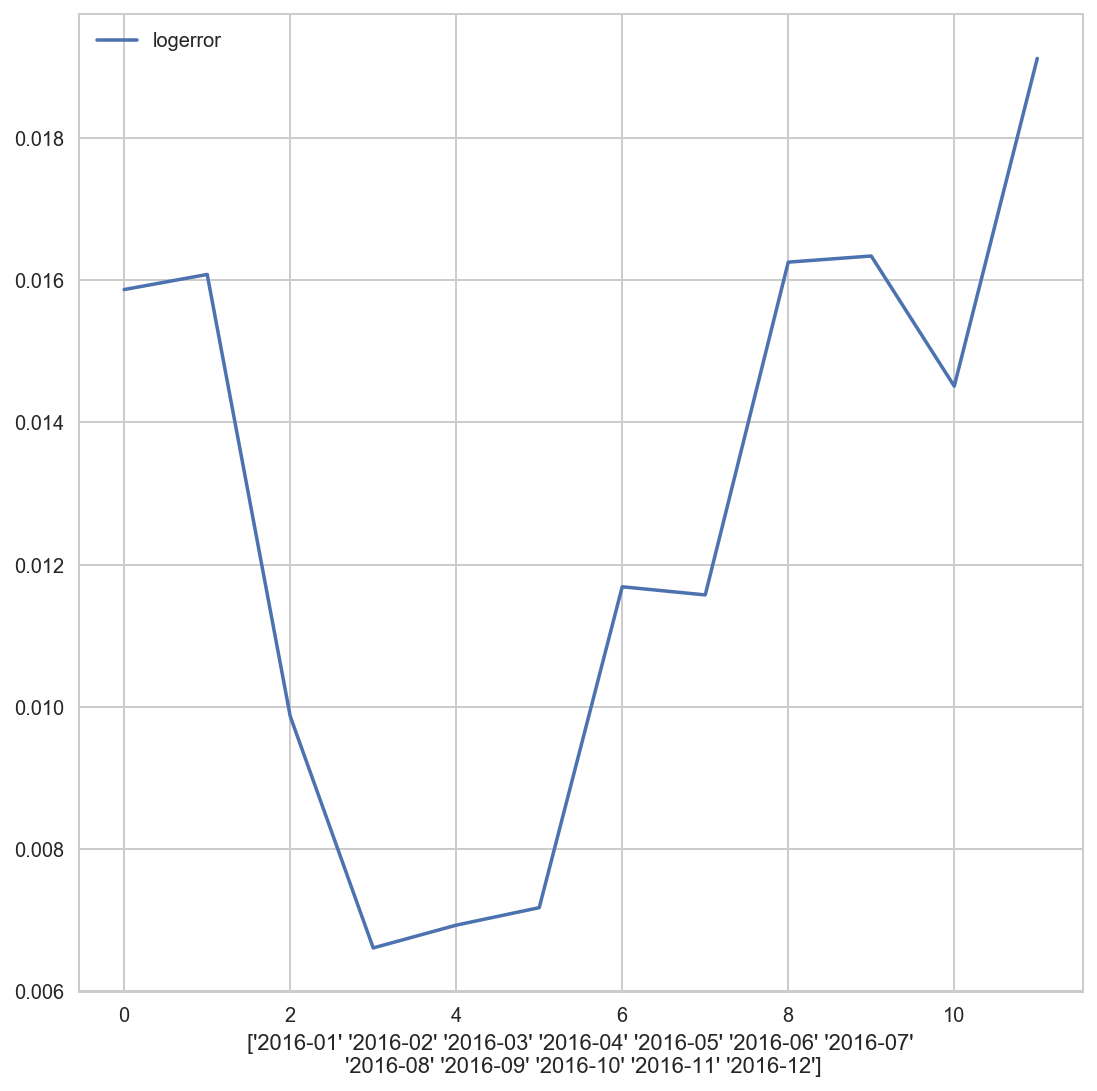

In [11]:
train_16[["logerror", 'transactiondate']].groupby(np.array([x[:7] for x in train_16.transactiondate]), axis=0).agg(np.mean).reset_index().plot(figsize=(9, 9))
plt.xlabel(np.unique([x[:7] for x in train_16.transactiondate]))
plt.grid(True)

In [12]:
# _low = np.percentile(train_16.logerror, 1)
# _high = np.percentile(train_16.logerror, 99)
# plt.ylim((-0.10, 0.20))

# potentially_outliers = np.array([x[1:] for x in train_16.values if x[1] < _low or x[1] > _high])
# plt.scatter(potentially_outliers[:, 1], potentially_outliers[:, 0], marker='o', c="r", alpha=0.5, s=5)

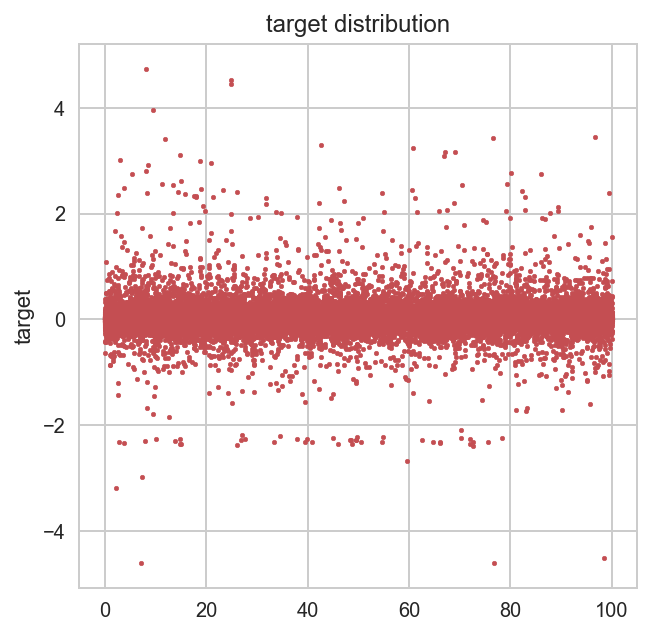

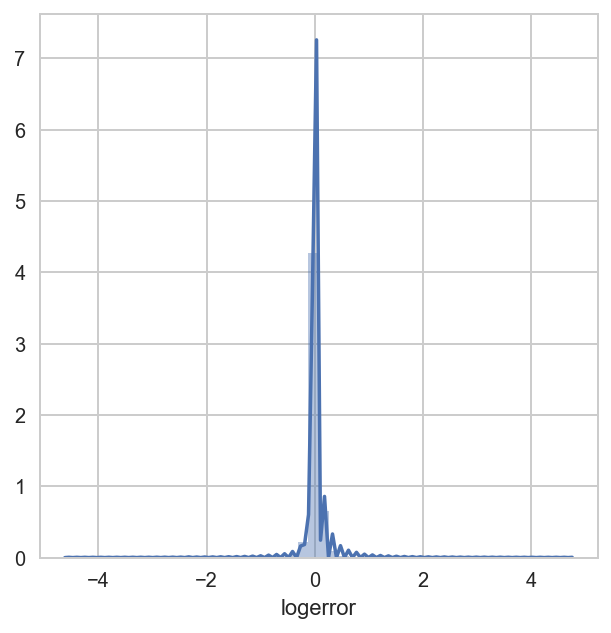

In [13]:
plt.figure(1, figsize=(5, 5))
plt.title("target distribution")
plt.ylabel("target")
plt.scatter(np.linspace(0, 100, len(train_16)), train_16.logerror,c='r', s=5)
plt.figure(2, figsize=(5, 5))
sns.distplot(train_16.logerror)

omnibus test
NormaltestResult(statistic=66168.2675135686, pvalue=0.0)

jarque_bera test
 'test statistics', p-value
(64984381.32242768, 0.0)

Kolmogorov-Smirnov test
 'test statistics', p-value
(0.21846846471941828, 0.0)


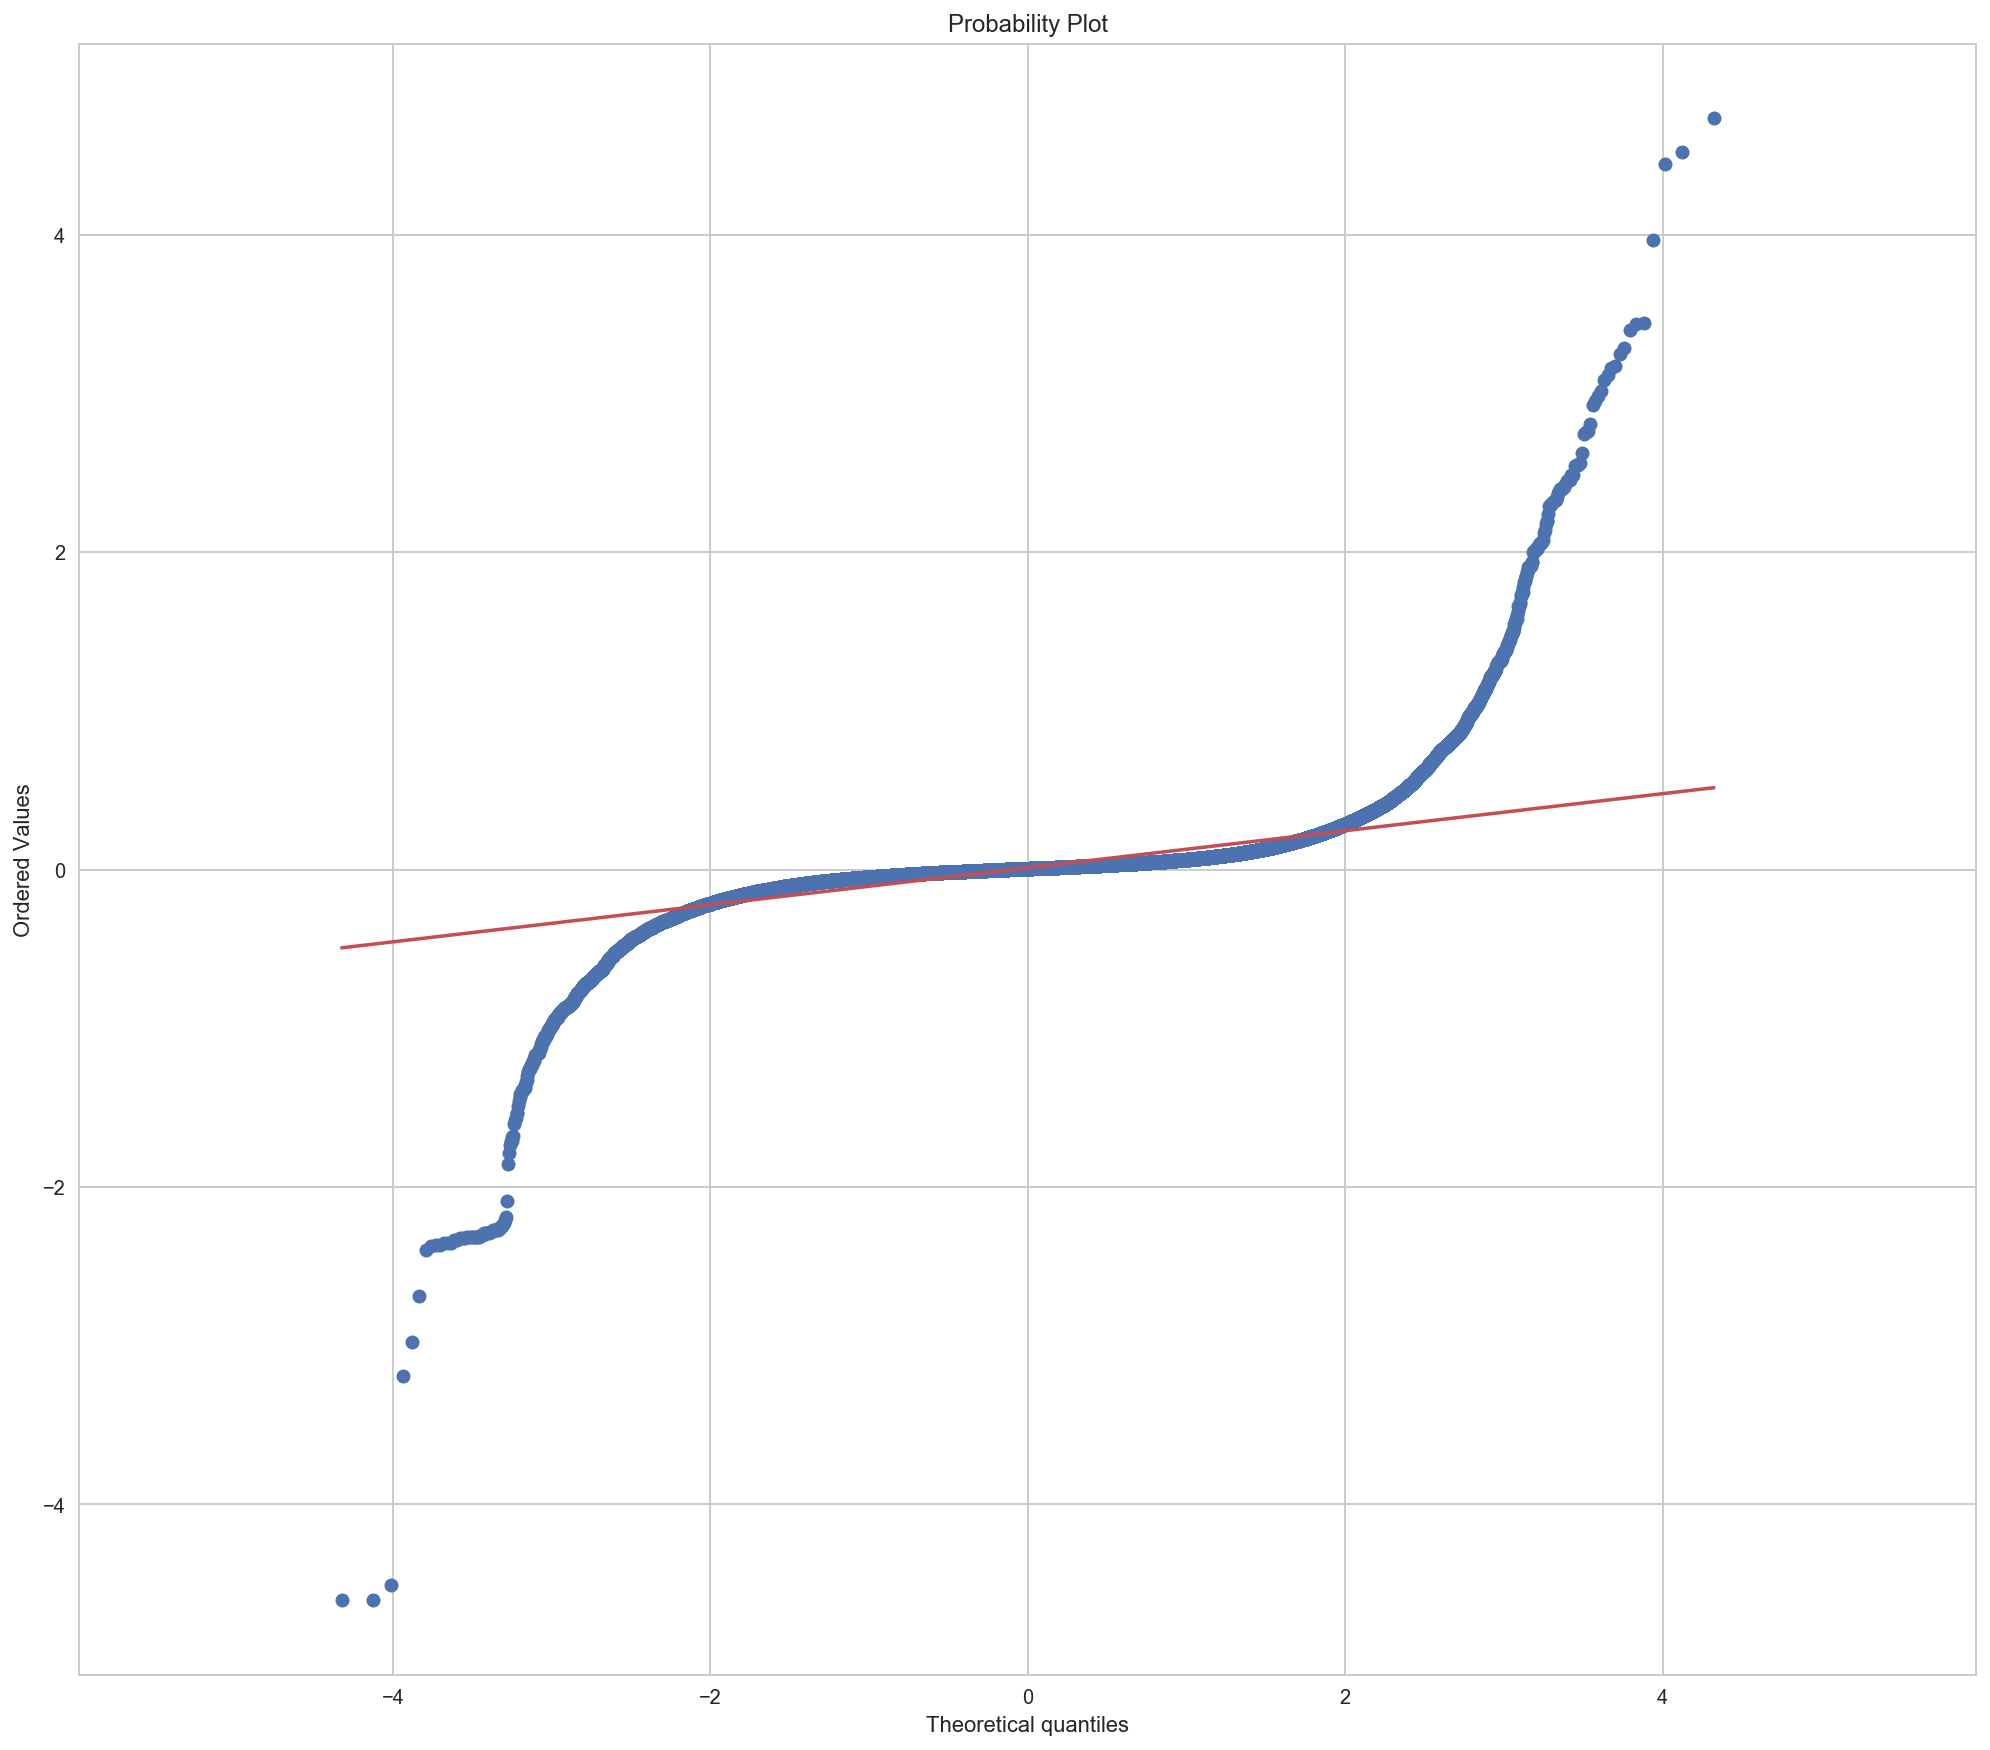

In [15]:
# normality test 
print("omnibus test")
print(stats.stattools.omni_normtest(train_16.logerror))
print("\njarque_bera test\n 'test statistics', p-value")
print(stats.stattools.jarque_bera(train_16.logerror)[:2])
print("\nKolmogorov-Smirnov test\n 'test statistics', p-value")
print(stats.diagnostic.kstest_normal(train_16.logerror))

# logerror doesn't follow normal distribution -> need to check null hypothesis 

# train's logerror follows 
# qq plot & normality test 
plt.figure(figsize=(17, 15))
sp.stats.probplot(train_16.logerror, plot=plt)
plt.axis("equal")
plt.show()

## Properties_16



In [17]:
# column_name : explanation ; dict type" 
with open("../Data/data_dict.p", "rb") as f:
    data_dict = pickle.load(f) 

In [18]:
for i in properties_16.columns[:5]:
    print("- " + i)
    print(data_dict["{}".format(i)],end="\n\n")

- parcelid
,Unique identifier for parcels (lots) 

- airconditioningtypeid
,Type of cooling system present in the home (if any)

- architecturalstyletypeid
,Architectural style of the home (i.e. ranch, colonial, split-level, etc…)

- basementsqft
,Finished living area below or partially below ground level

- bathroomcnt
,Number of bathrooms in home including fractional bathrooms



In [19]:
print(len(np.unique(properties_16.parcelid)))
properties_16.tail()

2985217


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def missing_percentage(df):
    res = []
    for col in df.columns:
        res.append(1 - len(df["{}".format(col)].dropna()) /\
                   len(df["{}".format(col)]))
    
    return pd.Series(np.array(res), index=df.columns)

def newline(p1, p2):
    import matplotlib.lines as mlines
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color="#000000")
    ax.add_line(l)
    return l

### so many mising values 

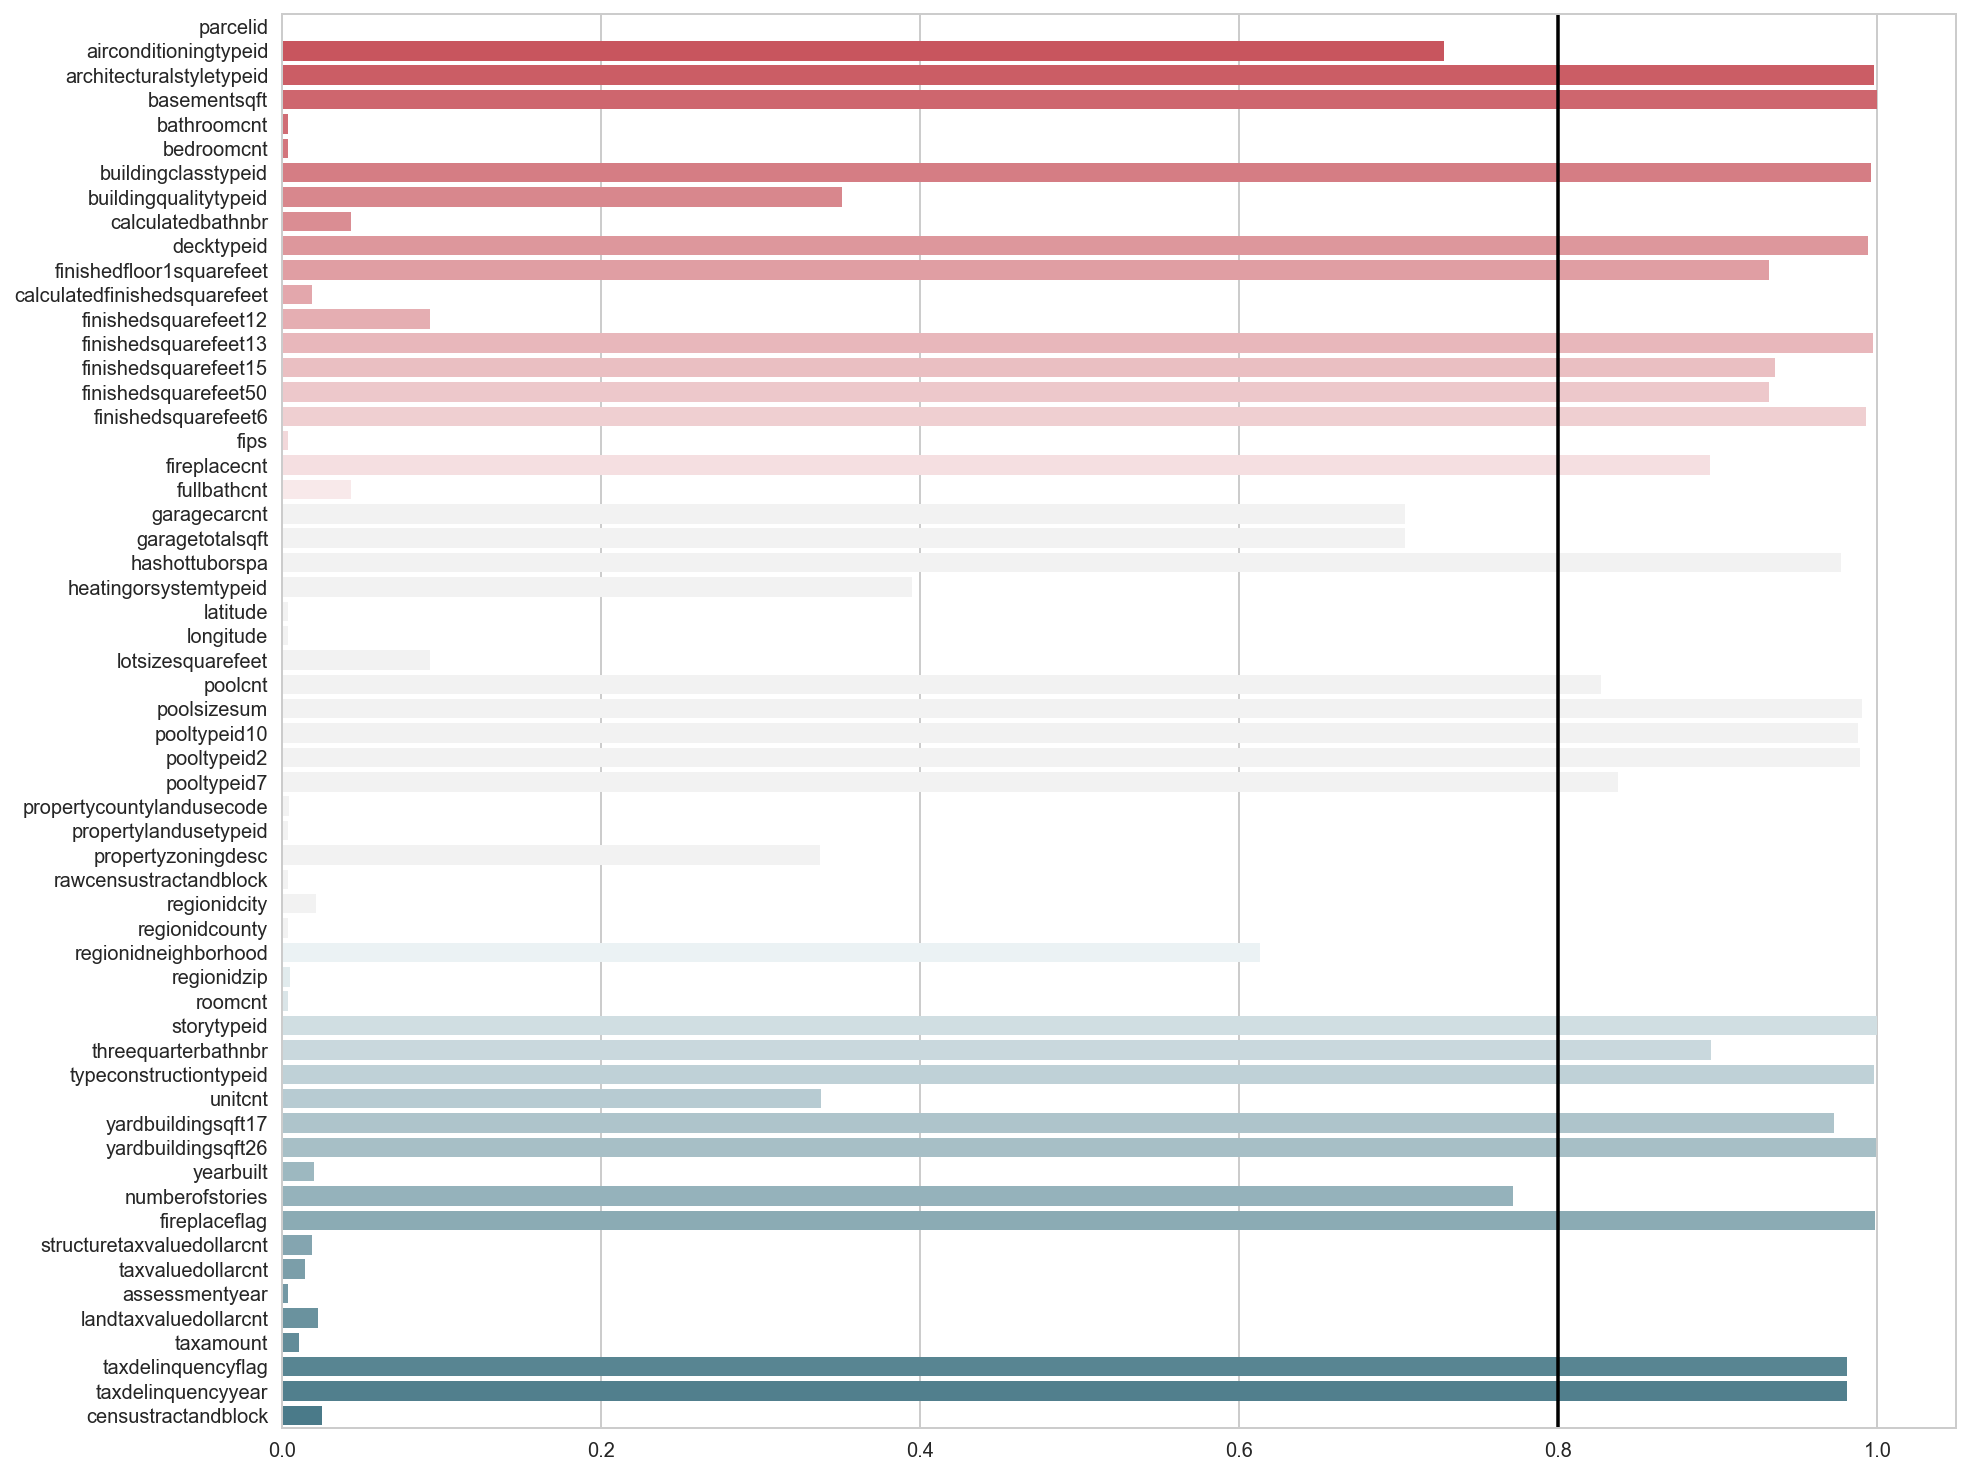

In [21]:
properties_16_missing_ratio = missing_percentage(properties_16)
# properties_16_missing_ratio
plt.figure(figsize=(15, 13))
cmap = sns.diverging_palette(10, 220, sep=80, n=len(properties_16_missing_ratio.index))
sns.set_color_codes("deep")
sns.barplot(properties_16_missing_ratio.values, properties_16_missing_ratio.index, palette=cmap)
# plt.legend(ncol=1, loc="lower right", frameon=True)
# plt.set(xlim=(0, 24), ylabel="",
#        xlabel="missing ratio of each columns in properties_16")
# sns.despine(left=True, bottom=True)
# plt.plot([0.8, properties_16_missing_ratio.index[-1]], [0.8, properties_16_missing_ratio.index[0]])

p1 = [0.8,0]
p2 = [0.8,20]
newline(p1,p2) # a border line to demonstrate columns which has over 80% of its amount of missing value
plt.show()

In [22]:
# for i in properties_16.columns:
#     if properties_16["{}".format(i)].dtypes == "object":
#         continue
#     data = properties_16["{}".format(i)].dropna().values
#     x_ = np.linspace(0, 100, len(data))
#     plt.title("{}".format(i))
#     plt.scatter(x_, data)
#     plt.show()

In [28]:
for i in properties_16.columns:
    try : 
        print("- {}".format(i))
        print(len(np.unique(properties_16[i])), end="\n\n")
    except :
        properties_16["{}".format(i)] = [str(x) for x in properties_16["{}".format(i)]]
        print(len(np.unique(properties_16[i])), end="\n\n")


- parcelid
2985217

- airconditioningtypeid
2173705

- architecturalstyletypeid
2979164

- basementsqft
2984340

- bathroomcnt
11499

- bedroomcnt
11471

- buildingclasstypeid
2972593

- buildingqualitytypeid
1046741

- calculatedbathnbr
128946

- decktypeid
2968122

- finishedfloor1squarefeet
2787104

- calculatedfinishedsquarefeet
68152

- finishedsquarefeet12
286703

- finishedsquarefeet13
2977795

- finishedsquarefeet15
2803235

- finishedsquarefeet50
2787302

- finishedsquarefeet6
2967467

- fips
11440

- fireplacecnt
2672589

- fullbathcnt
128932

- garagecarcnt
2101974

- garagetotalsqft
2104190

- hashottuborspa
2977275

- heatingorsystemtypeid
1178830

- latitude
863762

- longitude
1053987

- lotsizesquarefeet
346052

- poolcnt
2467684

- poolsizesum
2958164

- pooltypeid10
2948279

- pooltypeid2
2953143

- pooltypeid7
2499759

- propertycountylandusecode
241

- propertylandusetypeid
11452

- propertyzoningdesc
5639

- rawcensustractandblock
110830

- regionidcity
63031

- re

### 차례대로 봐 봅시다. 
- airconditioningtypeid :
2173705

- architecturalstyletypeid
2979164

- basementsqft
2984340

- bathroomcnt
11499

- bedroomcnt
11471

- buildingclasstypeid
2972593

- buildingqualitytypeid
1046741

- calculatedbathnbr
128946

- decktypeid
2968122

- finishedfloor1squarefeet
2787104

- calculatedfinishedsquarefeet
68152

- finishedsquarefeet12
286703

- finishedsquarefeet13
2977795

- finishedsquarefeet15
2803235

- finishedsquarefeet50
2787302

- finishedsquarefeet6
2967467

- fips
11440

- fireplacecnt
2672589

- fullbathcnt
128932

- garagecarcnt
2101974

- garagetotalsqft
2104190

- hashottuborspa
2977275

- heatingorsystemtypeid
1178830

- latitude
863762

- longitude
1053987

- lotsizesquarefeet
346052

- poolcnt
2467684

- poolsizesum
2958164

- pooltypeid10
2948279

- pooltypeid2
2953143

- pooltypeid7
2499759

- propertycountylandusecode
241

- propertylandusetypeid
11452

- propertyzoningdesc
5639

- rawcensustractandblock
110830

- regionidcity
63031

- regionidcounty
11440

- regionidneighborhood
1829343

- regionidzip
14385

- roomcnt
11511

- storytypeid
2983594

- threequarterbathnbr
2673593

- typeconstructiontypeid
2978475

- unitcnt
1007873

- yardbuildingsqft17
2906498

- yardbuildingsqft26
2983164

- yearbuilt
60096

- numberofstories
2303160

- fireplaceflag
2984944

- structuretaxvaluedollarcnt
481132

- taxvaluedollarcnt
681470

- assessmentyear
11453

- landtaxvaluedollarcnt
599141

- taxamount
1077007

- taxdelinquencyflag
2

- taxdelinquencyyear
2928785

- censustractandblock
171897

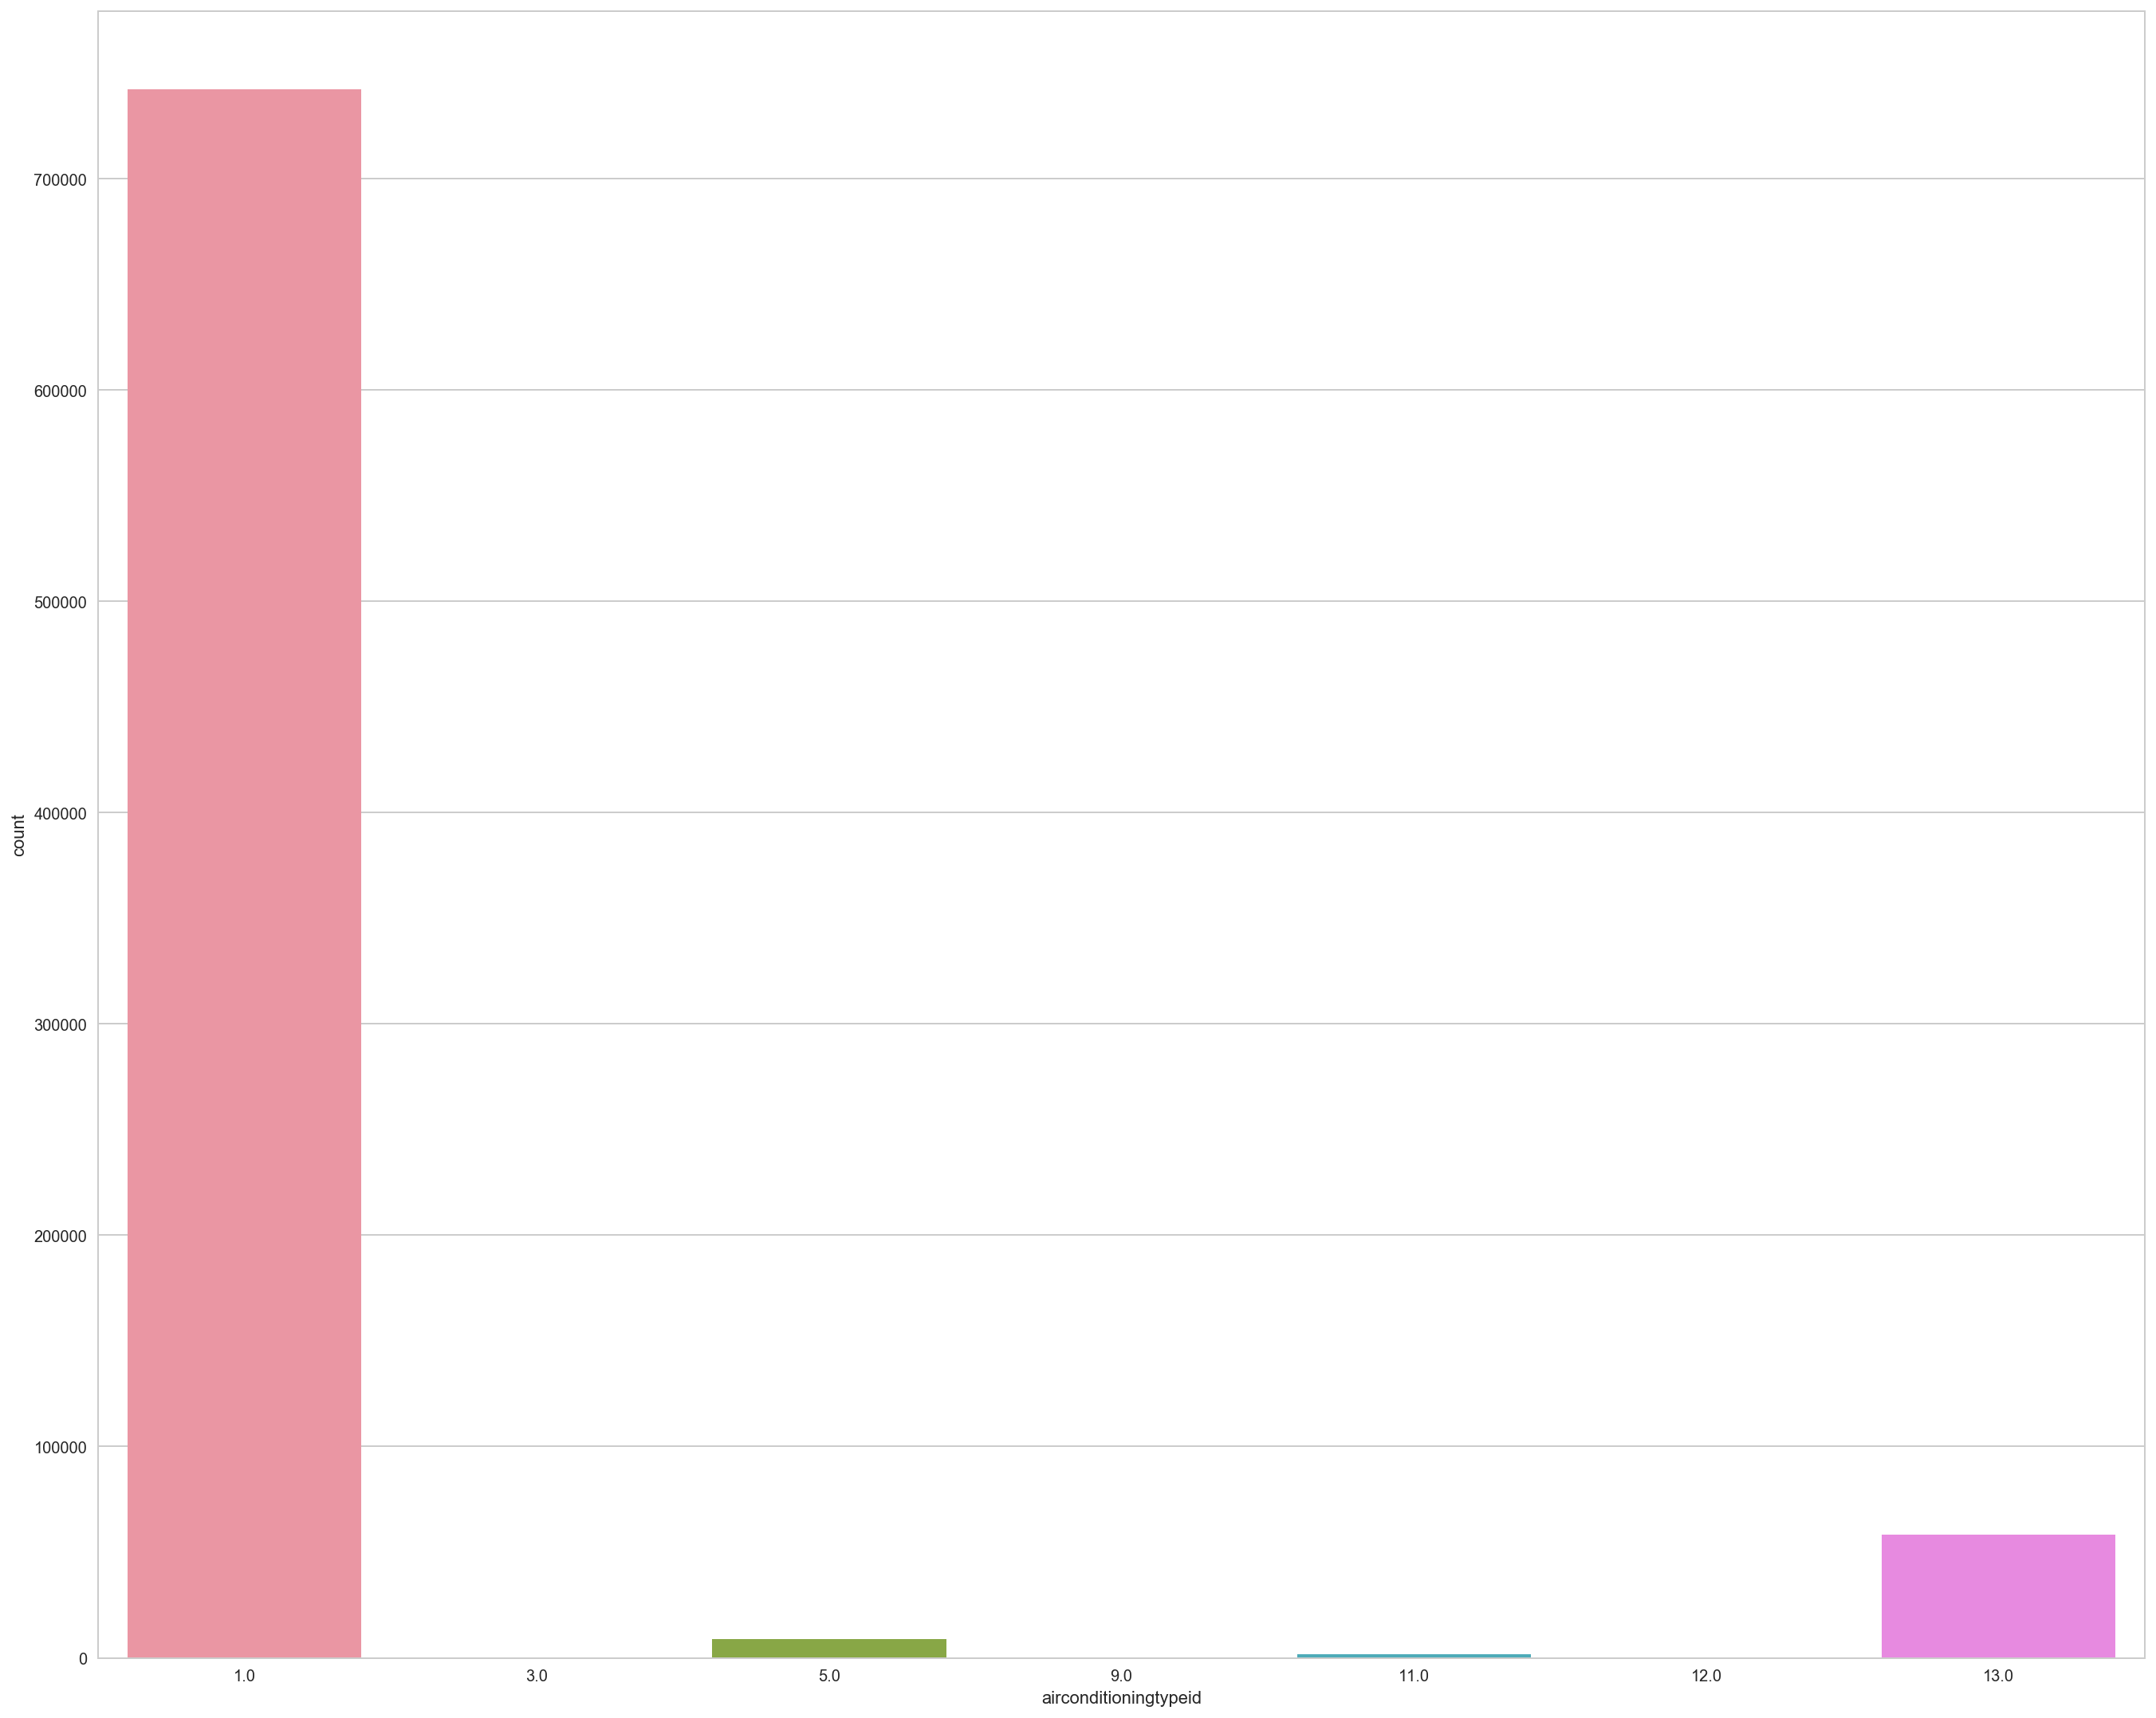

In [61]:
# properties_16.airconditioningtypeid

sns.countplot(properties_16.airconditioningtypeid) # type - 1 이 월등히 많다. 타입과 타겟값의 상관관계가 있을까 ? 
# 없으면 그냥type 이 1 인지 아닌지 혹은 특별한 상관관계가 있는 타입인가 아닌가로 축소 할 수 있을 듯 하다. 

In [40]:
# this columns nan has to be filled an category 
print(data_dict["taxdelinquencyflag"])
val, counts = np.unique(properties_16["taxdelinquencyflag"], return_counts=True)
pd.DataFrame([counts], columns=val)

,Property taxes for this parcel are past due as of 2015


,Y,nan
0,56462,2928755


In [54]:
np.unique(properties_16.hashottuborspa.dropna())

array([True], dtype=object)